In [1]:
import os
import time
import numpy as np
import pandas as pd

import graphviz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree, ensemble
from sklearn.metrics import roc_auc_score


from cfmining.algorithms import BruteForce, Greedy, MAPOCAM
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier, GeneralClassifier
from cfmining.visualization import buildTable, FeatureImportance, PlotCounterfactuals
from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet

plt.style.use('seaborn-deep')

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
prob = 0.82

# Read in the data

In [4]:
data_dir = "data/"
data_name = 'german'
data_file = os.path.join(data_dir, '%s_processed.csv' % data_name)
## load and process data
german_df = pd.read_csv(data_file).reset_index(drop=True)
german_df = (german_df
             .assign(isMale=lambda df: (df['Gender']=='Male').astype(int))
             .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
            )

y = german_df['GoodCustomer']
X = german_df.drop('GoodCustomer', axis=1)

In [5]:
random_state = 2500
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=100, random_state=random_state)

## Train a simple tree model

In [6]:
clf_rt = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf_rt.fit(Xtr, ytr);

In [7]:
print('AUC performance:', roc_auc_score(yts, clf_rt.predict(Xts)))

AUC performance: 0.5230664857530529


## Show tree

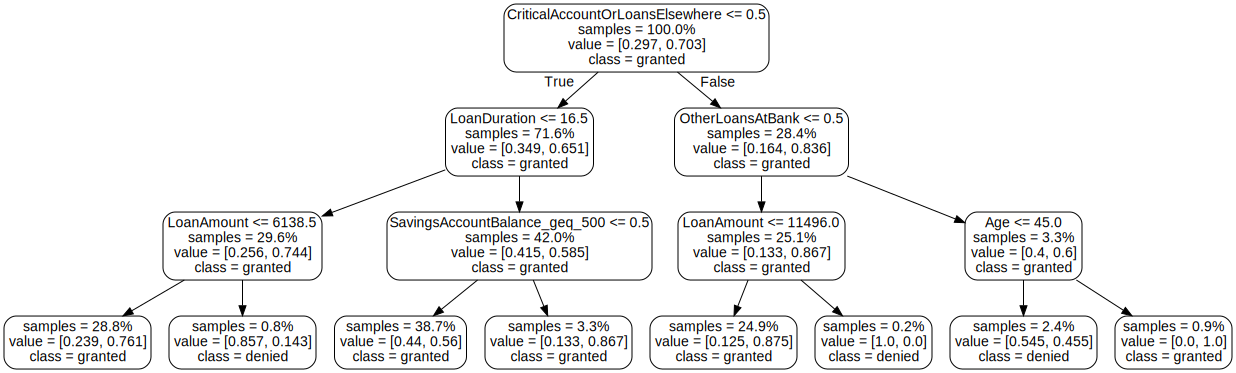

In [8]:
# Visualize the tree
from IPython.display import display
g1 = graphviz.Source(tree.export_graphviz(clf_rt, rotate=False, label='all', rounded=True, impurity=False, proportion=True, feature_names=X.columns, class_names=['denied', 'granted']))
g1.render(filename='plot/tree_example.dot')
display(g1)

## Preparing action set

Here we assume, a priori, how the action should behave.

In [9]:
action_set = ActionSet(X = X)

for feat in action_set:
    if feat.name in ['LoanDuration']:
        feat.step_type ="absolute"
        feat.step_size = 6
        feat.update_grid()
    else:
        feat.step_type ="relative"
        feat.step_size = 0.1
    feat.update_grid()

for feat in action_set:
    if feat.name in ['Age', 'Single', 'JobClassIsSkilled', 'ForeignWorker', 'OwnsHouse', 'RentsHouse', 'isMale', 'Age', 'LoanDuration', 'LoanAmount']:
        feat.mutable = False
        feat.flip_direction = 1
        feat.step_direction = 1
    if feat.name in ['LoanRateAsPercentOfIncome', 'NumberOfOtherLoansAtBank', 'MissedPayments',
                     'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'RentsHouse', 'Unemployed', 'YearsAtCurrentJob_lt_1']:
        feat.mutable = True
        feat.flip_direction = -1
        feat.step_direction = -1
    if feat.name in ['YearsAtCurrentHome', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
                     'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
                     'NoCurrentLoan', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']:
        feat.mutable = True
        feat.flip_direction = 1
        feat.step_direction = 1
    feat.update_grid()

## Preparing sample to be actionable

In [10]:
scores = pd.Series(clf_rt.predict_proba(Xts)[:, 1], index=Xts.index)
denied_individuals = scores[scores < .8].index

In [11]:
choice = 850
choice = choice if choice in denied_individuals else np.random.choice(denied_individuals)
print('Choice:', choice)
individual = Xts.loc[choice].values

Choice: 850


## Preparing criterias

In [12]:
percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)

## Enumerate counterfactuals

In [13]:
env_clf = GeneralClassifier(clf_rt, Xtr, ytr, threshold=prob)

/home/marcos/Documents/Experiments/envs/mapocam/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/marcos/Documents/Experiments/envs/mapocam/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
en = MAPOCAM(action_set, individual, env_clf, max_changes=3)
start = time.perf_counter()
en.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.2147457110695541


## Counterfactual summary

In [15]:
names = action_set.df['name'].values
overview_clean = buildTable(en, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en, individual, percCriteria, names, include_original=True, include_cost=True)

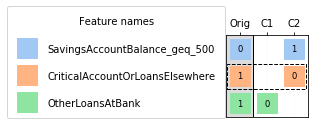

In [16]:
pltW = PlotCounterfactuals(overview_clean, individual)
pltW.show('plot/actions_tree_example.pdf', hl_row=[1], bbox_to_anchor=(-0.01, -0.01))

## Exploring neural networks

In [17]:
from sklearn.neural_network import MLPClassifier

In [18]:
#random_state = np.random.randint(100000)
#random_state = 53550
random_state = 34265
clf_nn = MLPClassifier(solver='adam', alpha=0, tol=1e-10, max_iter=10**5,
                       hidden_layer_sizes=(10, 5, 2, 5, 10), random_state=random_state,
                       learning_rate='adaptive', n_iter_no_change=1000,
                       activation='relu',)#, early_stopping=True)

In [19]:
clf_nn.fit(Xtr, ytr)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 5, 2, 5, 10), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=100000,
              momentum=0.9, n_iter_no_change=1000, nesterovs_momentum=True,
              power_t=0.5, random_state=34265, shuffle=True, solver='adam',
              tol=1e-10, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [20]:
random_state

34265

In [21]:
print('AUC performance:', roc_auc_score(yts, clf_nn.predict(Xts)))
print('AUC performance:', roc_auc_score(ytr, clf_nn.predict(Xtr)))

AUC performance: 0.6605608322026233
AUC performance: 0.6745566856595133


In [22]:
clf_nn.predict_proba([individual])

array([[0.29376144, 0.70623856]])

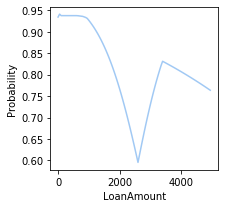

In [23]:
LoanAmount = np.arange(0, 5000, 50)
idx = X.columns.get_loc('LoanAmount')
pLoanAmount = []
for l in LoanAmount:
    aux = individual.copy()
    aux[idx] = l
    pLoanAmount.append(clf_nn.predict_proba([aux])[0,1])
plt.rcParams["figure.figsize"] = [3,3]
plt.ylabel('Probability')
plt.xlabel('LoanAmount')
plt.plot(LoanAmount, pLoanAmount)

plt.savefig('plot/nn_LoanAmount.eps', bbox_inches='tight')
plt.show()

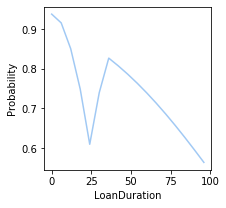

In [24]:
LoanDuration = np.arange(0, 100, 6)
idx = X.columns.get_loc('LoanDuration')
pLoanDuration = []
for l in LoanDuration:
    aux = individual.copy()
    aux[idx] = l
    pLoanDuration.append(clf_nn.predict_proba([aux])[0,1])
plt.rcParams["figure.figsize"] = [3,3]
plt.ylabel('Probability')
plt.xlabel('LoanDuration')
plt.plot(LoanDuration, pLoanDuration)
plt.savefig('plot/nn_LoanDuration.eps', bbox_inches='tight')
plt.show()

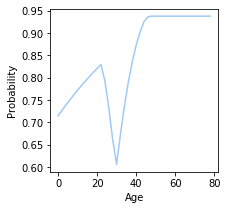

In [25]:
Age = np.arange(0, 80, 2)
idx = X.columns.get_loc('Age')
pAge = []
for l in Age:
    aux = individual.copy()
    aux[idx] = l
    pAge.append(clf_nn.predict_proba([aux])[0,1])
plt.rcParams["figure.figsize"] = [3,3]
plt.ylabel('Probability')
plt.xlabel('Age')
plt.plot(Age, pAge)
plt.savefig('plot/nn_Age.eps', bbox_inches='tight')
plt.show()

In [26]:
env_nn = GeneralClassifier(clf_nn, Xtr, ytr, threshold=prob)

In [47]:
en = MAPOCAM(action_set, individual, env_nn, max_changes=3)
start = time.perf_counter()
en.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.18474405095912516


In [48]:
names = action_set.df['name'].values
overview_clean = buildTable(en, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en, individual, percCriteria, names, include_original=True, include_cost=True)

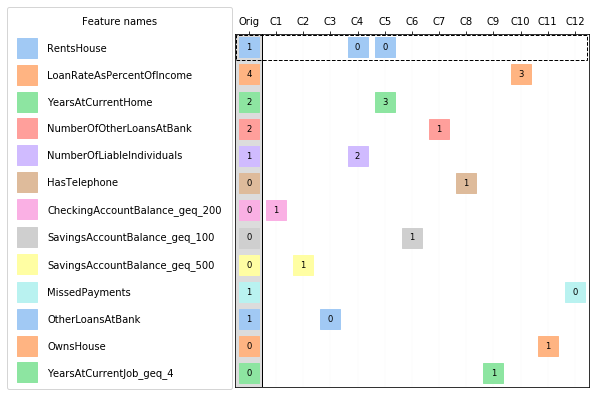

In [49]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/actions_nn_example.pdf', hl_row=[12], bbox_to_anchor=(-0.01, -0.005))

## Exploring random forests

In [30]:
random_tree = ensemble.RandomForestClassifier()
random_tree.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
print('AUC performance:', roc_auc_score(yts, random_tree.predict(Xts)))

AUC performance: 0.629127091813659


Poor performance, let's try other classifier

## Boosted trees

In [32]:
import lightgbm as lgb

In [33]:
boost_tree = lgb.LGBMClassifier()
boost_tree.fit(Xtr, ytr)#, min_child_samples=5)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [34]:
print('AUC performance:', roc_auc_score(yts, boost_tree.predict(Xts)))

AUC performance: 0.6824966078697422


In [35]:
boost_tree_env = GeneralClassifier(boost_tree, Xtr, ytr, threshold=prob)

In [36]:
en = MAPOCAM(action_set, individual, boost_tree_env, max_changes=3)#, compare=NonDomCriterion(individual, action_set))
start = time.perf_counter()
en.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.8220214110333472


In [37]:
names = action_set.df['name'].values
overview_clean = buildTable(en, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en, individual, percCriteria, names, include_original=True, include_cost=True)

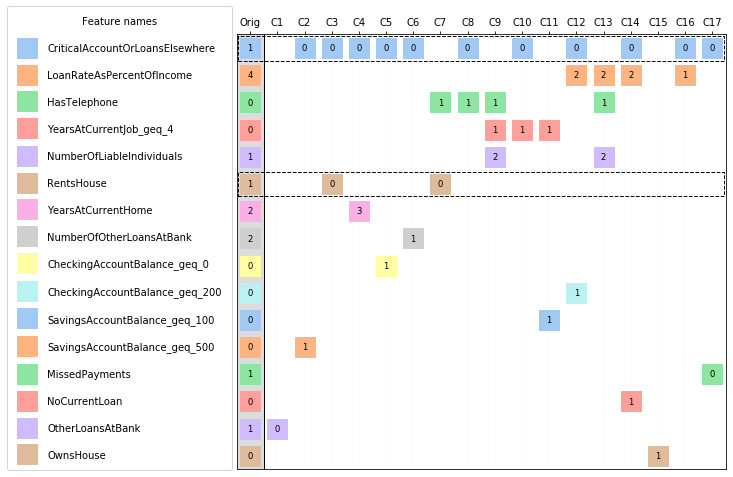

In [38]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/actions_tree_boost.pdf', hl_row=[15, 10], bbox_to_anchor=(-0.01, -0.001))

## Exploring monotonicity constraints in boosted trees

In [39]:
mon_constr = [feat.step_direction if feat.mutable else 0 for feat in action_set]

In [40]:
boost_tree_mon = lgb.LGBMClassifier(monotone_constraints=mon_constr, min_child_samples=5)
boost_tree_mon.fit(Xtr, ytr);

In [41]:
print('AUC performance:', roc_auc_score(yts, boost_tree_mon.predict(Xts)))

AUC performance: 0.599502487562189


In [42]:
boost_tree_mon_env = GeneralClassifier(boost_tree_mon, Xtr, ytr, threshold=prob)

In [43]:
en = MAPOCAM(action_set, individual, boost_tree_mon_env, max_changes=3)#, compare=NonDomCriterion(individual, action_set))
start = time.perf_counter()
en.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.5645517299417406


In [44]:
names = action_set.df['name'].values
overview_clean = buildTable(en, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en, individual, percCriteria, names, include_original=True, include_cost=True)

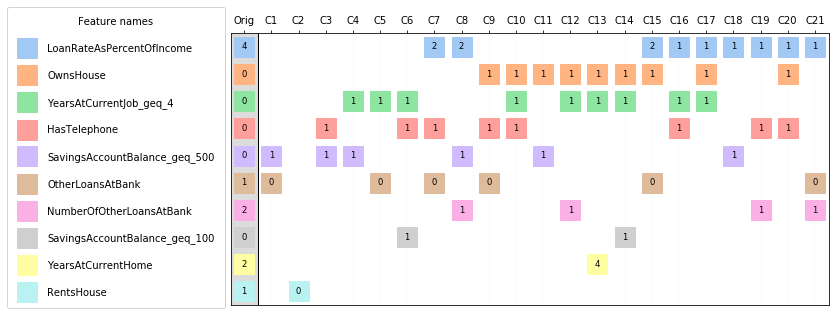

In [45]:
pltW = PlotCounterfactuals(overview_clean, individual)
pltW.show('plot/actions_tree_mon_boost.pdf', bbox_to_anchor=(-0.01, -0.01))